In [1]:
import numpy as np

from models.CM1DLayers import IlluminationLayer, ZNCCLayer, IFFTReconLayer
from dataset.dataset import SampleLabels
from utils.torch_utils import *
from felipe_utils.research_utils.signalproc_ops import gaussian_pulse

import matplotlib.pyplot as plt
import matplotlib
import yaml

In [2]:

rep_freq = 5 * 1e6
rep_tau = 1. / rep_freq
sigma = 30

counts = torch.Tensor([1000] * 10)
sbr = torch.Tensor([0.1] * 10)

n_tbins = 1024
k = 8

In [3]:
tbin_res = rep_tau / n_tbins
tbin_res_depth = (3e8 * tbin_res) / 2.

print(f'time bin resolution {tbin_res_depth * 1000:.3f} mm')

time bin resolution 29.297 mm


In [4]:
inits = ['TruncatedFourier',
         'experiments/illum_models/version_2/checkpoints/coded_model.ckpt']

In [5]:
sample_data = SampleLabels(n_tbins, sources=counts, sbrs=sbr, num_samples=200)
samples = sample_data.labels
depths = torch.tensor([sample[0] for sample in sample_data.labels])
photon_counts = torch.tensor([sample[1] for sample in sample_data.labels])
sbrs = torch.tensor([sample[2] for sample in sample_data.labels])

gt_depths = bin2depth(depths, num_bins=n_tbins, tau=rep_tau)



hirf is NONE
t_domain is None
Fourier coding K=8
torch.Size([20000, 8, 1])
MAE TR: 98.106 mm 
torch.Size([20000, 8, 1])
MAE Ver.2: 61.400 mm 


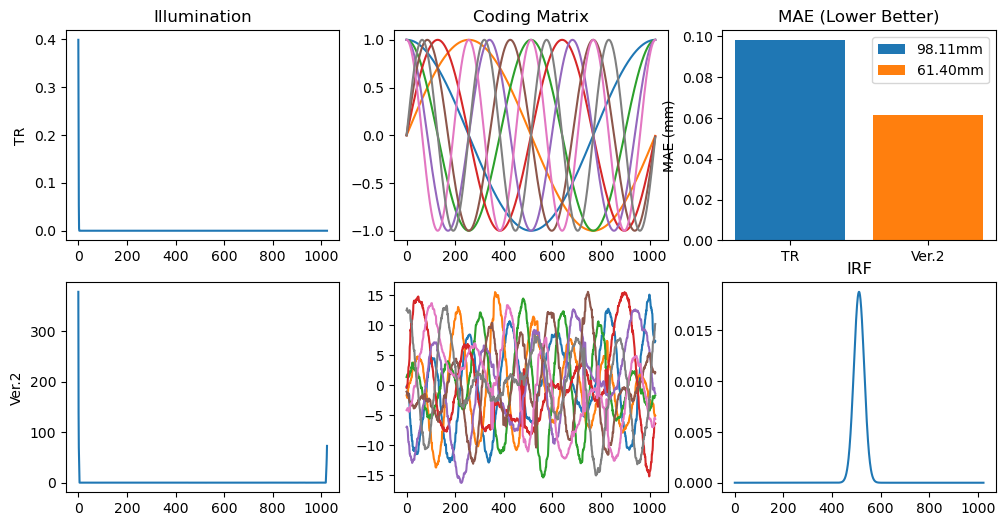

: 

In [ ]:
fig, axs = plt.subplots(len(inits), 3, figsize=(12, 6))
counter = 0
names = []
for init in inits:
    if init.endswith('.ckpt'): 
        get_from_model = True
        with open(os.path.join('experiments/illum_models', init.split('/')[-3], 'hparams.yaml'), 'r') as f:
            hparams = yaml.load(f, Loader=yaml.FullLoader)
            n_tbins = hparams['n_tbins']
            k = hparams['k']
        name = 'Ver.' + init.split('/')[-3].split('_')[-1]
    else: 
        get_from_model = False
        k = 8
        n_tbins = 1024
        name = 'TR'

    model = IlluminationLayer(k=k, n_tbins=n_tbins, init=init, sigma=sigma, get_from_model=get_from_model)

    zncc_layer = ZNCCLayer()
    ifft_layer = IFFTReconLayer(n_tbins)

    c_vals = model(depths, photon_counts, sbrs)

    print(c_vals.shape)
    exit(0)

    if init.endswith('Fourier'):
        pred_depths = ifft_layer(c_vals)
    else:
        pred_depths = zncc_layer(c_vals, model.cmat1D.weight.data.detach().clone())

    pred_depths = bin2depth(pred_depths, num_bins=n_tbins, tau=rep_tau)
    
    loss = torch.mean(torch.abs(pred_depths.squeeze() - gt_depths.squeeze()))
    #loss = criterion_RMSE(pred_depths, gt_depths)

    print(f'MAE {name}: {loss * 1000:.3f} mm ')
    names.append(name)
    cmat = model.cmat1D.weight
    cmat = np.transpose(cmat.detach().numpy().squeeze())

    #illum = model.irf_layer(model.illumination.view(1, n_tbins)).view(n_tbins, 1).numpy().squeeze()
    #illum[illum < 0] = 0
    illum = model.illumination.numpy().squeeze()
    axs[counter][0].plot(illum)
    axs[counter][0].set_ylabel(name)
    axs[counter][1].plot(cmat)
    
    #axs[counter][1].set_title(init.split('/')[-1].split('.')[0])

    axs[0][2].bar(counter, loss, label=f'{loss * 1000:.2f}mm')
    axs[0][2].set_title('MAE (Lower Better)')
    axs[0][2].set_ylabel('MAE (mm)')


    axs[0][1].set_title('Coding Matrix')
    axs[0][0].set_title('Illumination')

    if counter >= 1 and counter < len(inits)-1:
        axs[counter][2].set_axis_off()

    counter += 1

axs[0][2].set_xticks(np.arange(0, len(inits)))
axs[0][2].set_xticklabels(names)
axs[0][2].legend()

pulse_domain = np.arange(0, n_tbins)
pulse = gaussian_pulse(pulse_domain, mu=pulse_domain[-1] // 2, width=sigma, circ_shifted=True)

axs[-1][2].plot(pulse.squeeze())
axs[-1][2].set_title('IRF')


plt.show(block=True)
